In [2]:
import numpy as np
from numpy import random
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from keras.models import load_model
from tensorflow.keras.layers import Dense
import pydicom as dicom
import tensorflow_io as tfio
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor
import SimpleITK as sitk


# Training

In [2]:
dict = './train/'

# Function takes a list of folders, extract features from it, change the extractor inside function and the return dictionary
# to run exactly which feature, the key of the return dictionary can be found in mask.ipy and also listed in pyradiomics library
def LoadDataFromImages(foldernames):
    input_images = []
    feature_values = []

    extractor = RadiomicsFeatureExtractor()
    extractor.disableAllFeatures()
    extractor.enableFeaturesByName(firstorder=[feature_name])

    for folder in folder_names:
        folder_path = os.path.join(DATA_DIRECTORY, folder)
        files = os.listdir(folder_path)
        
        for file_name in files:
            image_path = os.path.join(folder_path, file_name)
            image = sitk.ReadImage(image_path)
            image_array = sitk.GetArrayFromImage(image)[0].reshape(512, 512, 1)
            input_images.append(image_array)

            mask_array = np.ones(image.GetSize()[::-1])  # Correcting dimension order
            mask_image = sitk.GetImageFromArray(mask_array)
            mask_image.CopyInformation(image)
            
            features = extractor.execute(image, mask_image)
            feature_key = f'original_firstorder_{feature_name}'
            feature_values.append(features[feature_key])

    return np.array(input_images), np.array(feature_values)

# Define the folders to process
folder_names = [
    'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12',
    'd2_6', 'd2_7', 'd2_8', 'd2_9', 'd2_10', 'd2_11', 'd2_12',
    'd3_1', 'd3_2', 'd3_3', 'd3_4', 'd3_5', 'd3_6', 'd3_7', 'd3_8' 
]

In [3]:
input_array, output_array = LoadDataFromImages(folder_names)

# Load and test

2/2 [==============================] - 0s 6ms/step


Text(0.5, 1.0, 'ClusterShade K1 set Performance')

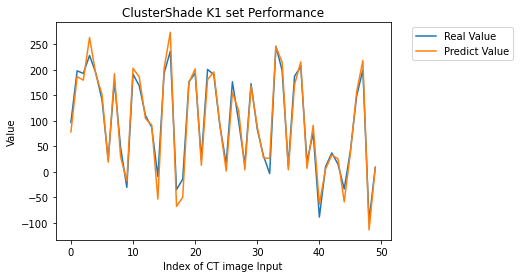

In [187]:
model = load_model('vali.h5')
input_array_t, output_array_t = LoadDataFromImages(['t3'])


plt.plot(range(50),output_array_t[200:250] ,label='Real Value')
plt.plot(range(50),model.predict(output_array_t[200:250])  ,label='Predict Value')
plt.xlabel("Index of CT image Input")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.title('ClusterShade K1 set Performance')


# Fine Tune

In [2]:
base_model =  load_model("radiomics_gldm_DependenceVariance.h5")

In [3]:
# how many layers for saving
newlayers = base_model.layers[7].output
n1 = Dense(526, activation='relu', name = 'dense_41')(newlayers)
out = Dense(1, activation='linear', name = 'DependenceVariance' )(n1)
new_model = keras.Model(base_model.input, outputs = out)

In [4]:
for i in range(len(base_model.layers)): 
    keras.layers.trainable = True   # True--> fine tine, False-->frozen
    
# print("Number of layers in the base model: ", len(base_model.layers))
# print("Number of layers in the new model: ", len(new_model.layers))

In [6]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.0001
), loss="mse")

In [7]:
new_model.fit(input_array, output_array, 
              epochs=500, 
          batch_size=64,
                shuffle=True
            )